In [1]:
# most of this code taken from https://github.com/anordertoreclaim/PixelCNN - asked cat he said should be okay to use :)


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np


class CroppedConv2d(nn.Conv2d):
    """
    A convolution that returns two outputs:
      1. The full convolution result, with the bottom row(s) cropped off.
      2. A vertically-shifted version (shifted up by 1 pixel).
    Used in Gated/Causal blocks to separate vertical and horizontal stacks.
    """
    def __init__(self, *args, **kwargs):
        super(CroppedConv2d, self).__init__(*args, **kwargs)

    def forward(self, x):
        x_conv = super(CroppedConv2d, self).forward(x)
        kernel_height, _ = self.kernel_size

        # 1. main result with bottom row cropped off
        main_out = x_conv[:, :, 1:-kernel_height, :]

        # 2. vertically shifted output
        shifted_up = x_conv[:, :, :-kernel_height-1, :]

        return main_out, shifted_up


class MaskedConv2d(nn.Conv2d):
    """
    Masked convolution for PixelCNN:
      - mask_type = 'A' (strictly no access to future/present pixel)
      - mask_type = 'B' (can access current pixel in the channel, but not future)
      - data_channels: number of input channels (1 for MNIST).
    """
    def __init__(self, *args, mask_type, data_channels, **kwargs):
        super(MaskedConv2d, self).__init__(*args, **kwargs)
        assert mask_type in ['A', 'B'], "mask_type must be 'A' or 'B'."
        self.mask_type = mask_type
        self.data_channels = data_channels

        out_channels, in_channels, kh, kw = self.weight.shape
        yc, xc = kh // 2, kw // 2  # center row/col

        # Start with all zeros
        mask = np.zeros((out_channels, in_channels, kh, kw), dtype=np.float32)

        # Everything above the center row is valid
        mask[:, :, :yc, :] = 1
        # Everything up to and including the center pixel in the center row is valid
        mask[:, :, yc, :xc + 1] = 1

        # Channel-wise masking logic (mostly relevant for multi-channel/color images).
        def channel_mask(out_c, in_c):
            a = (np.arange(out_channels) % self.data_channels == out_c)[:, None]
            b = (np.arange(in_channels) % self.data_channels == in_c)[None, :]
            return a * b

        # Disallow "future" channels from the center pixel
        for o in range(self.data_channels):
            for i in range(o + 1, self.data_channels):
                mask[channel_mask(o, i), yc, xc] = 0

        # Type A also disallows "same" channel at the center
        if self.mask_type == 'A':
            for c in range(self.data_channels):
                mask[channel_mask(c, c), yc, xc] = 0

        mask = torch.from_numpy(mask)
        self.register_buffer('mask', mask)

    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)




class CausalBlock(nn.Module):
    """
    The initial block for PixelCNN. Splits the flow into vertical and horizontal stacks.
    """
    def __init__(self, in_channels, out_channels, kernel_size, data_channels):
        super(CausalBlock, self).__init__()
        self.split_size = out_channels

        # Vertical stack
        self.v_conv = CroppedConv2d(in_channels,
                                    2 * out_channels,
                                    (kernel_size // 2 + 1, kernel_size),
                                    padding=(kernel_size // 2 + 1, kernel_size // 2))
        self.v_fc = nn.Conv2d(in_channels, 2 * out_channels, kernel_size=1)
        self.v_to_h = nn.Conv2d(2 * out_channels, 2 * out_channels, kernel_size=1)

        # Horizontal stack
        self.h_conv = MaskedConv2d(in_channels,
                                   2 * out_channels,
                                   kernel_size=(1, kernel_size),
                                   padding=(0, kernel_size // 2),
                                   mask_type='A',
                                   data_channels=data_channels)

        self.h_fc = MaskedConv2d(out_channels,
                                 out_channels,
                                 kernel_size=1,
                                 mask_type='A',
                                 data_channels=data_channels)

    def forward(self, x):
        # x: [B, C, H, W]
        v_out, v_shifted = self.v_conv(x)
        v_out += self.v_fc(x)

        # Gating
        v_tanh, v_sig = torch.split(v_out, self.split_size, dim=1)
        v_out = torch.tanh(v_tanh) * torch.sigmoid(v_sig)

        h_out = self.h_conv(x)
        v_shifted = self.v_to_h(v_shifted)
        h_out += v_shifted
        h_tanh, h_sig = torch.split(h_out, self.split_size, dim=1)
        h_out = torch.tanh(h_tanh) * torch.sigmoid(h_sig)
        h_out = self.h_fc(h_out)

        return v_out, h_out


class GatedBlock(nn.Module):
    """
    Typical gating block for PixelCNN layers after the first. 
    Uses mask_type='B' so it can also see the current channel/pixel.
    """
    def __init__(self, in_channels, out_channels, kernel_size, data_channels, num_classes=None):
        super(GatedBlock, self).__init__()
        self.split_size = out_channels
        self.label_emb = None
        if num_classes is not None and num_classes > 0:
            self.label_emb = nn.Embedding(num_classes, 2*out_channels)

        self.v_conv = CroppedConv2d(in_channels,
                                    2 * out_channels,
                                    (kernel_size // 2 + 1, kernel_size),
                                    padding=(kernel_size // 2 + 1, kernel_size // 2))
        self.v_fc = nn.Conv2d(in_channels, 2 * out_channels, kernel_size=1)
        self.v_to_h = MaskedConv2d(2 * out_channels,
                                   2 * out_channels,
                                   kernel_size=1,
                                   mask_type='B',
                                   data_channels=data_channels)

        self.h_conv = MaskedConv2d(in_channels,
                                   2 * out_channels,
                                   kernel_size=(1, kernel_size),
                                   padding=(0, kernel_size // 2),
                                   mask_type='B',
                                   data_channels=data_channels)
        self.h_fc = MaskedConv2d(out_channels,
                                 out_channels,
                                 kernel_size=1,
                                 mask_type='B',
                                 data_channels=data_channels)

        self.h_skip = MaskedConv2d(out_channels,
                                   out_channels,
                                   kernel_size=1,
                                   mask_type='B',
                                   data_channels=data_channels)

    def forward(self, v_in, h_in, skip, labels=None):
        v_out, v_shifted = self.v_conv(v_in)
        v_out += self.v_fc(v_in)

        if self.label_emb is not None and labels is not None:
            label_emb = self.label_emb(labels).unsqueeze(-1).unsqueeze(-1)
            v_out += label_emb

        v_tanh, v_sig = torch.split(v_out, self.split_size, dim=1)
        v_out = torch.tanh(v_tanh) * torch.sigmoid(v_sig)

        h_temp = self.h_conv(h_in)
        v_shifted = self.v_to_h(v_shifted)
        h_temp += v_shifted

        if self.label_emb is not None and labels is not None:
            h_temp += label_emb

        h_tanh, h_sig = torch.split(h_temp, self.split_size, dim=1)
        h_temp = torch.tanh(h_tanh) * torch.sigmoid(h_sig)

        skip_out = skip + self.h_skip(h_temp)
        h_temp = self.h_fc(h_temp)

        h_out = h_temp + h_in
        v_out = v_out + v_in
        return v_out, h_out, skip_out


class PixelCNN(nn.Module):
    """
    Full PixelCNN model:
     - CausalBlock for initial vertical+horizontal split
     - Multiple GatedBlocks
     - 1x1 conv layers -> final logits
    """
    def __init__(
        self,
        hidden_fmaps=32,
        out_hidden_fmaps=32,
        causal_ksize=7,
        hidden_ksize=7,
        hidden_layers=4,
        color_levels=256,
        num_classes=10,
        data_channels=1
    ):
        super().__init__()
        self.data_channels = data_channels
        self.color_levels = color_levels
        self.hidden_fmaps = hidden_fmaps
        self.out_hidden_fmaps = out_hidden_fmaps
        self.num_classes = num_classes

        self.causal_conv = CausalBlock(
            in_channels=data_channels,
            out_channels=hidden_fmaps,
            kernel_size=causal_ksize,
            data_channels=data_channels
        )
        self.gated_blocks = nn.ModuleList([
            GatedBlock(
                in_channels=hidden_fmaps,
                out_channels=hidden_fmaps,
                kernel_size=hidden_ksize,
                data_channels=data_channels,
                num_classes=num_classes
            )
            for _ in range(hidden_layers)
        ])

        self.out_hidden = MaskedConv2d(
            hidden_fmaps,
            out_hidden_fmaps,
            kernel_size=1,
            mask_type='B',
            data_channels=data_channels
        )
        self.out_conv = MaskedConv2d(
            out_hidden_fmaps,
            data_channels * color_levels,
            kernel_size=1,
            mask_type='B',
            data_channels=data_channels
        )

    def forward(self, x, labels=None):
        B, C, H, W = x.size()
        v, h = self.causal_conv(x)

        skip = x.new_zeros((B, self.hidden_fmaps, H, W))
        for gb in self.gated_blocks:
            v, h, skip = gb(v, h, skip, labels=labels)

        out = F.relu(skip)
        out = F.relu(self.out_hidden(out))
        out = self.out_conv(out)  # [B, data_channels*color_levels, H, W]

        # reshape to [B, color_levels, data_channels, H, W]
        out = out.view(B, self.color_levels, self.data_channels, H, W)
        return out

    @torch.no_grad()  # sampling is not part of the training graph
    def sample(self, shape, n=1, labels=None, device='cpu'):
        """
        Sample images pixel by pixel from the model.
        shape: (channels=1, H, W)
        n:     number of samples
        """
        C, H, W = shape
        samples = torch.zeros(n, C, H, W, device=device)

        # If no labels, pick random classes
        if labels is None:
            labels = torch.randint(0, self.num_classes, size=(n,), device=device)
        elif isinstance(labels, int):
            labels = torch.tensor([labels]*n, device=device)
        else:
            labels = torch.tensor(labels, device=device)

        for row in range(H):
            for col in range(W):
                out = self.forward(samples, labels=labels)  # [n, color_levels, 1, H, W]
                logits = out[:, :, 0, row, col]             # [n, color_levels]
                probs = F.softmax(logits, dim=-1)
                pixel_value = torch.multinomial(probs, 1).squeeze(1).float()
                samples[:, 0, row, col] = pixel_value / (self.color_levels - 1.0)

        return samples




In [2]:
# my code starts here :)

def show_images_grid(tensor_images, nrow=8, title=None):

    grid = make_grid(tensor_images.detach().cpu(), nrow=nrow, pad_value=1.0)
    # Convert CHW -> HWC for plotting
    npgrid = grid.permute(1, 2, 0).numpy()

    # Plot
    plt.figure(figsize=(nrow, 2))
    if npgrid.shape[-1] == 1:  # single-channel
        plt.imshow(npgrid[...,0], cmap='gray', vmin=0, vmax=1)
    else:
        plt.imshow(npgrid)
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()



Using device: mps


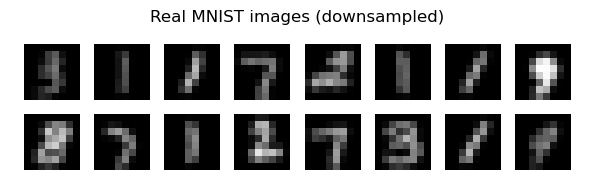

Epoch [1/5] average training loss: 2.6939


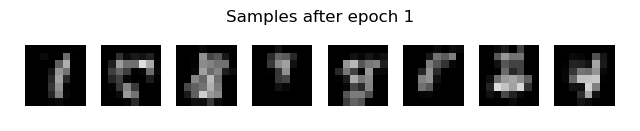

Epoch [2/5] average training loss: 2.3832


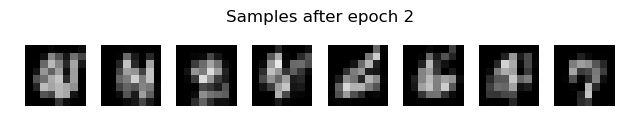

Epoch [3/5] average training loss: 2.3170


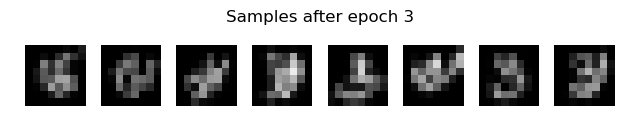

Epoch [4/5] average training loss: 2.2776


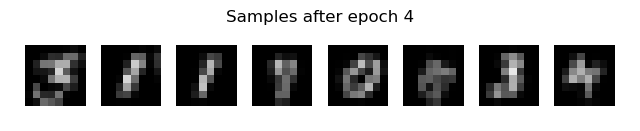

Epoch [5/5] average training loss: 2.2513


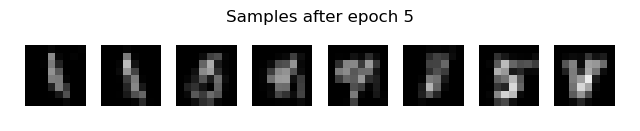

Training complete.


In [3]:


device = torch.device(
    'cuda' if torch.cuda.is_available() 
    else 'mps' if torch.backends.mps.is_available() 
    else 'cpu'
)
print("Using device:", device)

# Hyperparameters
batch_size = 64
epochs = 5
lr = 1e-3
color_levels = 256  # 8-bit grayscale
image_size = 8      # resize MNIST from 28x28 to 8x8

# Data
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),  # yields float in [0,1]
])
train_dataset = datasets.MNIST(root=".", train=True,  download=True, transform=transform)
test_dataset  = datasets.MNIST(root=".", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

# Show a small batch of real images to confirm
real_batch, real_labels = next(iter(train_loader))
show_images_grid(real_batch[:16], nrow=8, title="Real MNIST images (downsampled)")

# Model
model = PixelCNN(
    hidden_fmaps=32,
    out_hidden_fmaps=32,
    causal_ksize=3,   # smaller kernel for speed
    hidden_ksize=3,
    hidden_layers=4,
    color_levels=color_levels,
    num_classes=10,
    data_channels=1
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Training loop
for epoch in range(1, epochs + 1):
    model.train()
    total_loss = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}", leave=False)
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)

        # Convert images to integer levels [0..255]
        x_int = (images * (color_levels - 1)).long()

        optimizer.zero_grad()
        logits = model(images, labels=labels)  # [B, color_levels, 1, H, W]
        logits = logits.squeeze(2)             # => [B, color_levels, H, W]
        loss = F.cross_entropy(logits, x_int.squeeze(1))  # target [B,H,W]
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch}/{epochs}] average training loss: {avg_loss:.4f}")

    # Sample a small batch each epoch
    model.eval()
    samples = model.sample((1, image_size, image_size), n=8, device=device)
    # Show the generated samples
    show_images_grid(samples, nrow=8, title=f"Samples after epoch {epoch}")

print("Training complete.")



# Implementation Note

A significant portion of this code is based on the [PixelCNN repository](https://github.com/anordertoreclaim/PixelCNN). Initially, I attempted to implement WaveNet, but after consultation, I was advised that PixelCNN would be a more suitable approach for this assignment.



---
*Reference: [PixelCNN Repository](https://github.com/anordertoreclaim/PixelCNN)*